In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Đọc file CSV
file_path = 'NLP DATASET.csv'  # Đường dẫn tới file CSV của bạn
data = pd.read_csv(file_path)

# Tách dữ liệu thành X (câu hỏi) và y (nhãn)
X = data['Question']
y = data['Label']

# Mã hóa nhãn thành số
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Chia tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Số lượng mẫu train:", len(X_train))
print("Số lượng mẫu test:", len(X_test))


Số lượng mẫu train: 960
Số lượng mẫu test: 240


In [114]:
# Khởi tạo Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Chuyển văn bản thành chuỗi số
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Đệm các chuỗi để có cùng độ dài
max_length = 50  # Giới hạn độ dài câu
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Kích thước từ điển
vocab_size = len(tokenizer.word_index) + 1
print("Số lượng từ trong từ điển:", vocab_size)


Số lượng từ trong từ điển: 1112


In [115]:
import fasttext

# Load FastText model từ file .bin
model = fasttext.load_model('cc.vi.300.bin')


In [117]:
print(model.get_word_vector('giá'))  # Lấy thử vector của từ "học"

[-1.22661091e-01  5.53636700e-02  1.41800478e-01  2.95930430e-02
 -8.27335566e-02 -5.50692640e-02 -4.30196524e-02 -2.86210012e-02
  6.81398809e-03 -8.39588344e-02 -5.96411936e-02  1.42467842e-02
 -1.48809537e-01 -4.79608923e-02 -5.97199649e-02 -3.35736163e-02
  8.58044401e-02 -1.00587510e-01 -7.94519261e-02 -8.71512964e-02
  2.08056364e-02  2.36146394e-02  8.23296383e-02 -8.33525285e-02
  3.77636999e-02  5.23726568e-02  3.54800746e-02 -4.42538597e-02
  7.16536939e-02 -1.62647814e-01  7.43294656e-02  1.16684809e-01
 -7.64077231e-02 -8.51804018e-02 -3.61620262e-02 -9.03779045e-02
 -1.81313902e-02 -1.05658799e-01  1.35168731e-02  9.71468315e-02
 -4.03170474e-02  3.45492736e-02 -7.48830661e-02  8.72363336e-03
  9.43266004e-02  7.62426257e-02  8.72331560e-02 -2.75415480e-02
  1.46978237e-02 -7.19945133e-03  1.11510210e-01 -3.43572088e-02
  2.73421183e-02  1.02511436e-01 -1.04237944e-01 -3.46672311e-02
  1.58031583e-02 -4.98940386e-02 -2.75668688e-02  8.98529887e-02
 -4.55422811e-02 -1.39262

In [118]:
# Xử lý từ trong tokenizer (chuyển thành chữ thường)
processed_word_index = {word.lower(): idx for word, idx in tokenizer.word_index.items()}

# Kiểm tra lại từ trong FastText
missing_words = 0
for word in processed_word_index.keys():
    try:
        _ = model.get_word_vector(word)  # Kiểm tra từ trong FastText
    except KeyError:
        missing_words += 1

print(f"Số từ không tìm thấy sau xử lý: {missing_words}/{len(processed_word_index)}")


Số từ không tìm thấy sau xử lý: 0/1111


In [120]:
import numpy as np

# Khởi tạo embedding_matrix
embedding_matrix = np.zeros((vocab_size, 300))  # vocab_size là kích thước từ điển

# Tạo embedding matrix từ FastText
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:  # Đảm bảo chỉ số không vượt quá vocab_size
        embedding_matrix[idx] = model.get_word_vector(word)

print("Embedding matrix đã được khởi tạo.")
print("Shape của embedding matrix:", embedding_matrix.shape)


Embedding matrix đã được khởi tạo.
Shape của embedding matrix: (1112, 300)


In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout


# Xây dựng mô hình
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=300, 
              weights=[embedding_matrix], 
              input_shape=(max_length,),  
              trainable=False),
    Bidirectional(LSTM(units=128, return_sequences=False)),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

# Compile mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Kiểm tra cấu trúc mô hình
model.summary()




Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 50, 300)        │       333,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,864 (3.01 MB)

 Trainable params: 456,264 (1.74 MB)

 Non-trainable params: 333,600 (1.27 MB)

In [131]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train_padded,
    y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test_padded, y_test),
    callbacks=[reduce_lr]
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2452 - loss: 1.9906 - val_accuracy: 0.6000 - val_loss: 1.2223 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7051 - loss: 0.9896 - val_accuracy: 0.7917 - val_loss: 0.6429 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8395 - loss: 0.5694 - val_accuracy: 0.8583 - val_loss: 0.5131 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8769 - loss: 0.3836 - val_accuracy: 0.8833 - val_loss: 0.4300 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8991 - loss: 0.3279 - val_accuracy: 0.8833 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9292 - loss: 0.2262 - val_accuracy: 0.8750 - val_loss: 0.3619 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9528 - loss: 0.1760 - val_acc

In [132]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Độ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8930 - loss: 0.4326
Độ chính xác trên tập kiểm tra: 90.00%


In [133]:
def predict_question(question):
    # Tokenize và pad câu hỏi
    sequence = tokenizer.texts_to_sequences([question])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Dự đoán
    prediction = model.predict(padded_sequence)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Dự đoán câu hỏi mới
new_question = "Tôi muốn biết tổng thống nước Mỹ bây giờ là ai?"
print("Loại câu hỏi:", predict_question(new_question))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Loại câu hỏi: Who


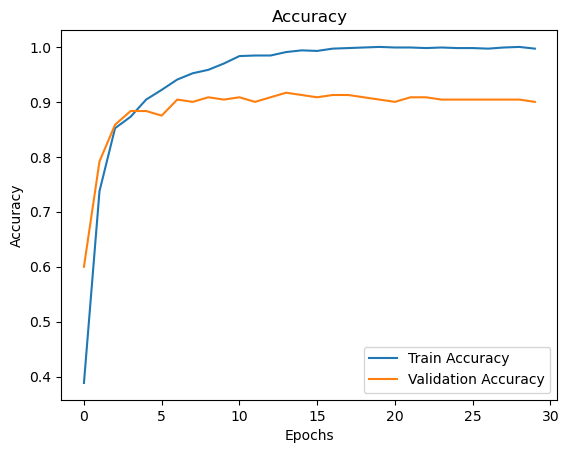

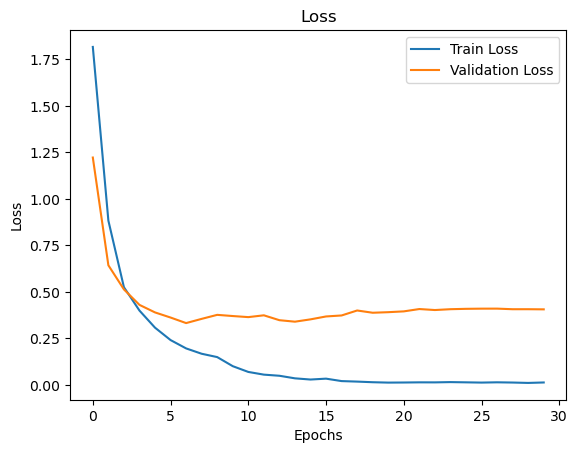

In [134]:
import matplotlib.pyplot as plt

# Vẽ đồ thị accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ đồ thị loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save('lstm_fasttext_model.h5')
import joblib
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
